In [1]:
import numpy as np
import pandas as pd
import MetaTrader5 as mt5
import warnings
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mpl_dates
import ta
import pytz
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import tensorflow as tf
import joblib
import statsmodels.api as sm
import statsmodels.formula.api as smf

from mpl_finance import candlestick_ohlc
from datetime import datetime
from matplotlib import cycler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from scipy.stats import randint, uniform
from scipy import stats
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras_tuner import HyperModel, Hyperband



warnings.filterwarnings("ignore")

C:\Users\aiman\anaconda\Lib\site-packages\mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


# Data Collection
## Account Initialisation

In [2]:
if not mt5.initialize():
    print("initialize() failed")
    mt5.shutdown()

account_number = '81866618'
password = 'R*HeYf3y'
server = 'MetaQuotes-Demo'

if not mt5.login(int(account_number), password=password, server=server):
    print("Failed to connect to the trading account")
    mt5.shutdown()
else:
    print("Connected to account #", account_number)


Connected to account # 81866618


# Data Collection

In [3]:
timezone = pytz.timezone("Etc/UTC")

timeframe = mt5.TIMEFRAME_D1  
utc_from = datetime(2018, 1, 1, tzinfo=timezone)  
utc_to = datetime(2023, 12, 31, tzinfo=timezone)    

rates = mt5.copy_rates_range("EURUSD", timeframe, utc_from, utc_to)

mt5.shutdown()

default = pd.DataFrame(rates)
default['time'] = pd.to_datetime(default['time'], unit='s')
default.set_index('time', inplace=True)

df = default
print(df.head())

               open     high      low    close  tick_volume  spread  \
time                                                                  
2018-01-02  1.20088  1.20812  1.20007  1.20579        92779       1   
2018-01-03  1.20579  1.20661  1.20010  1.20142       100595       1   
2018-01-04  1.20142  1.20889  1.20043  1.20678       109715       1   
2018-01-05  1.20678  1.20828  1.20206  1.20298       113628       1   
2018-01-08  1.20268  1.20523  1.19556  1.19669        88921       1   

            real_volume  
time                     
2018-01-02            0  
2018-01-03            0  
2018-01-04            0  
2018-01-05            0  
2018-01-08            0  


In [4]:
df

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2018-01-02,1.20088,1.20812,1.20007,1.20579,92779,1,0
2018-01-03,1.20579,1.20661,1.20010,1.20142,100595,1,0
2018-01-04,1.20142,1.20889,1.20043,1.20678,109715,1,0
2018-01-05,1.20678,1.20828,1.20206,1.20298,113628,1,0
2018-01-08,1.20268,1.20523,1.19556,1.19669,88921,1,0
...,...,...,...,...,...,...,...
2023-12-25,1.10119,1.10162,1.10119,1.10135,624,24,0
2023-12-26,1.10028,1.10451,1.09998,1.10415,97243,0,0
2023-12-27,1.10414,1.11229,1.10284,1.11043,163798,0,0


# Data Pre-Processing

In [5]:
df = df.iloc[:,:-2]
df.columns = ["open", "high", "low", "close", "volume"]
df.index.name = "time"
df

,open,high,low,close,volume
time,,,,,
2018-01-02,1.20088,1.20812,1.20007,1.20579,92779
2018-01-03,1.20579,1.20661,1.20010,1.20142,100595
2018-01-04,1.20142,1.20889,1.20043,1.20678,109715
2018-01-05,1.20678,1.20828,1.20206,1.20298,113628
2018-01-08,1.20268,1.20523,1.19556,1.19669,88921
...,...,...,...,...,...
2023-12-25,1.10119,1.10162,1.10119,1.10135,624
2023-12-26,1.10028,1.10451,1.09998,1.10415,97243
2023-12-27,1.10414,1.11229,1.10284,1.11043,163798


In [6]:
print(df.isnull().sum())
df.dropna(inplace=True)
df = (df - df.mean()) / df.std()

open      0
high      0
low       0
close     0
volume    0
dtype: int64


In [7]:
def remove_outliers(df, z_thresh=3):
    z_scores = np.abs((df - df.mean()) / df.std())
    return df[(z_scores < z_thresh).all(axis=1)]

df = remove_outliers(df)

In [8]:
df.to_csv('cleaned_data.csv')


# Trading Feature Engineering

In [9]:
df["returns"] = df["close"].pct_change(1)
essential_columns = ["open", "high", "low", "close", "volume"]

# Simple Moving Averages (SMA)
df["SMA_15"] = df["close"].rolling(window=15).mean().shift(1)
df["SMA_60"] = df["close"].rolling(window=60).mean().shift(1)

# Moving Standard Deviation (MSD)
df["MSD_10"] = df["returns"].rolling(window=10).std().shift(1)
df["MSD_30"] = df["returns"].rolling(window=30).std().shift(1)

# Relative Strength Index (RSI)
RSI = ta.momentum.RSIIndicator(df["close"], window=14, fillna=False)
df["RSI"] = RSI.rsi().shift(1)

# Exponential Moving Averages (EMA)
df['EMA_15'] = df['close'].ewm(span=15, adjust=False).mean().shift(1)
df['EMA_60'] = df['close'].ewm(span=60, adjust=False).mean().shift(1)

# Bollinger Bands
rolling_mean = df['close'].rolling(window=20).mean()
rolling_std = df['close'].rolling(window=20).std()
df['Bollinger_Upper'] = (rolling_mean + (rolling_std * 2)).shift(1)
df['Bollinger_Lower'] = (rolling_mean - (rolling_std * 2)).shift(1)

# MACD (Moving Average Convergence Divergence)
df['MACD'] = df['close'].ewm(span=12, adjust=False).mean() - df['close'].ewm(span=26, adjust=False).mean()
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean().shift(1)

# Stochastic Oscillator
df['Stochastic'] = ((df['close'] - df['low'].rolling(window=14).min()) / (df['high'].rolling(window=14).max() - df['low'].rolling(window=14).min())).shift(1)

# On-Balance Volume (OBV)
obv = (np.sign(df['close'].diff()) * df['volume']).fillna(0).cumsum()
df['OBV'] = obv.shift(1)

# Average Directional Index (ADX)
adx = ta.trend.ADXIndicator(high=df['high'], low=df['low'], close=df['close'], window=14, fillna=False)
df['ADX'] = adx.adx().shift(1)

df['Lagged_Returns_1'] = df['returns'].shift(1)
df['Lagged_Returns_2'] = df['returns'].shift(2)
df['Lagged_Returns_3'] = df['returns'].shift(3)

df['Rolling_Mean_5'] = df['returns'].rolling(window=5).mean().shift(1)
df['Rolling_Std_5'] = df['returns'].rolling(window=5).std().shift(1)

df.dropna(inplace=True)

def remove_outliers(df, z_thresh=3):
    z_scores = np.abs((df - df.mean()) / df.std())
    return df[(z_scores < z_thresh).all(axis=1)]

df = remove_outliers(df)

print(df.head())


                open      high       low     close    volume   returns  \
time                                                                     
2018-04-10  1.786553  1.831191  1.814268  1.851539  0.208612  0.033443   
2018-04-11  1.848599  1.863299  1.888843  1.870550 -0.016566  0.010267   
2018-04-12  1.866738  1.834948  1.808363  1.801297  0.041889 -0.037023   
2018-04-13  1.798590  1.777051  1.821523  1.806219 -0.386493  0.002733   
2018-04-16  1.804353  1.860054  1.848687  1.891427 -0.548921  0.047175   

              SMA_15    SMA_60    MSD_10    MSD_30  ...      MACD  \
time                                                ...             
2018-04-10  1.780068  1.722352  0.038859  0.052420  ... -0.002777   
2018-04-11  1.792765  1.730776  0.040035  0.050392  ...  0.005044   
2018-04-12  1.795978  1.740754  0.028593  0.049636  ...  0.005589   
2018-04-13  1.798298  1.748061  0.031532  0.048395  ...  0.006345   
2018-04-16  1.795763  1.756526  0.030894  0.047458  ...  0.013663  

In [10]:
df.to_csv('featureddata.csv')


## Correlation Analysis between Trading Features

In [11]:
corr_matrix = df.corr().abs()
print(corr_matrix)

                      open      high       low     close    volume   returns  \
open              1.000000  0.998492  0.998511  0.996317  0.418253  0.006144   
high              0.998492  1.000000  0.998404  0.998459  0.404010  0.007598   
low               0.998511  0.998404  1.000000  0.998504  0.434465  0.007038   
close             0.996317  0.998459  0.998504  1.000000  0.420653  0.007932   
volume            0.418253  0.404010  0.434465  0.420653  1.000000  0.021101   
returns           0.006144  0.007598  0.007038  0.007932  0.021101  1.000000   
SMA_15            0.984991  0.983155  0.983857  0.981481  0.400756  0.002258   
SMA_60            0.939601  0.937485  0.938008  0.935735  0.348519  0.000298   
MSD_10            0.017695  0.017925  0.020896  0.019178  0.076573  0.043318   
MSD_30            0.039231  0.038544  0.036505  0.036665  0.033864  0.046761   
RSI               0.134558  0.138192  0.132747  0.134569  0.122807  0.012112   
EMA_15            0.988869  0.986991  0.

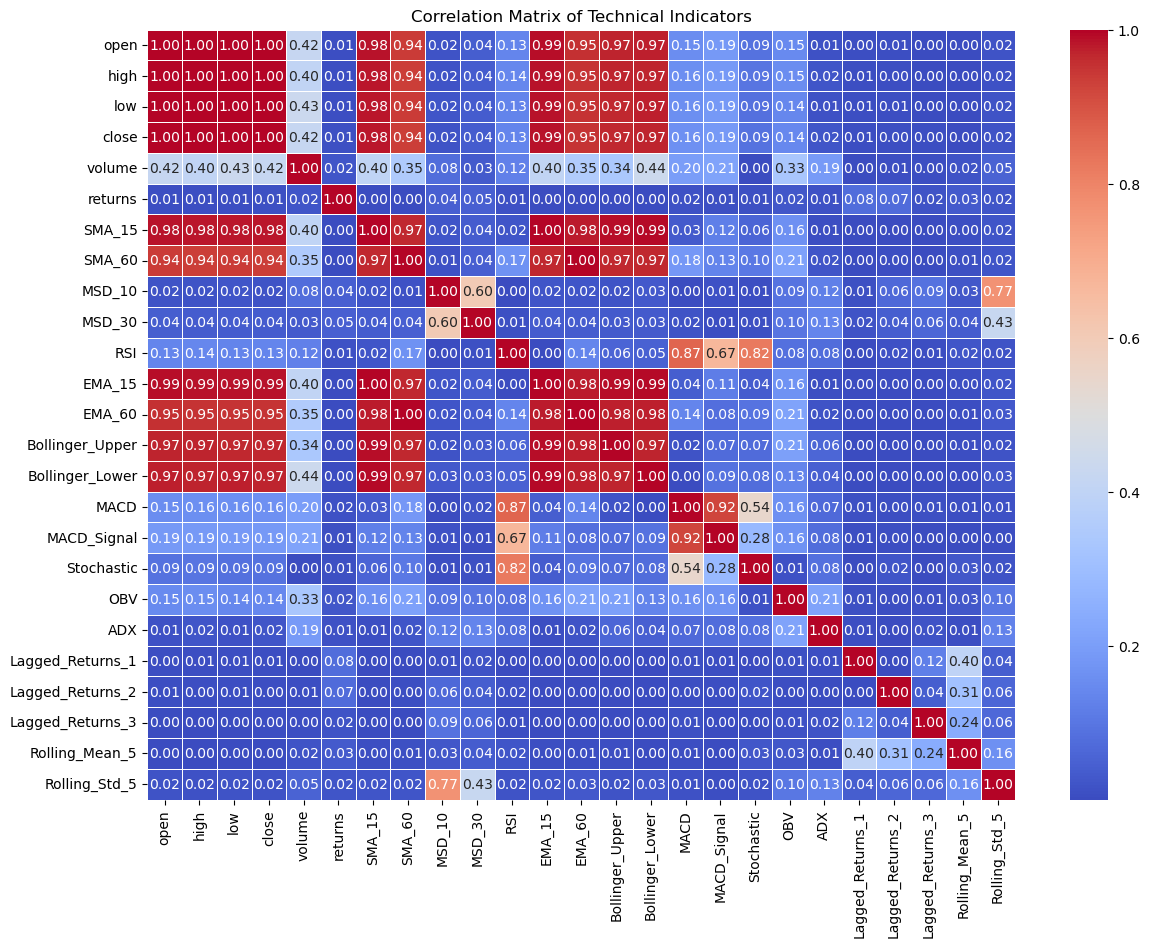

In [12]:
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Technical Indicators')
plt.show()

In [13]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9) and column not in essential_columns]
print("Highly correlated features (correlation > 0.9):", to_drop)

Highly correlated features (correlation > 0.9): ['SMA_15', 'SMA_60', 'EMA_15', 'EMA_60', 'Bollinger_Upper', 'Bollinger_Lower', 'MACD_Signal']


In [14]:
df = df.drop(columns=to_drop)

In [15]:
df

,open,high,low,close,volume,returns,MSD_10,MSD_30,RSI,MACD,Stochastic,OBV,ADX,Lagged_Returns_1,Lagged_Returns_2,Lagged_Returns_3,Rolling_Mean_5,Rolling_Std_5
time,,,,,,,,,,,,,,,,,,
2018-04-10,1.786553,1.831191,1.814268,1.851539,0.208612,0.033443,0.038859,0.052420,51.065120,-0.002777,0.376141,4.474234,10.356627,0.038877,0.041837,-0.037124,0.004155,0.037245
2018-04-11,1.848599,1.863299,1.888843,1.870550,-0.016566,0.010267,0.040035,0.050392,53.956618,0.005044,0.555734,4.682846,10.516026,0.033443,0.038877,0.041837,0.016959,0.033093
2018-04-12,1.866738,1.834948,1.808363,1.801297,0.041889,-0.037023,0.028593,0.049636,54.867829,0.005589,0.612716,4.666281,10.946521,0.010267,0.033443,0.038877,0.017460,0.032937
2018-04-13,1.798590,1.777051,1.821523,1.806219,-0.386493,0.002733,0.031532,0.048395,50.914865,0.006345,0.405141,4.624391,10.440276,-0.037023,0.010267,0.033443,0.017480,0.032896
2018-04-16,1.804353,1.860054,1.848687,1.891427,-0.548921,0.047175,0.030894,0.047458,51.184074,0.013663,0.419895,4.237898,9.970192,0.002733,-0.037023,0.010267,0.009659,0.030195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-13,-0.797677,-0.698183,-0.766336,-0.663293,-0.702810,-0.170461,0.099615,0.108847,48.831921,0.025492,0.141547,6.340619,23.950543,-0.059120,-0.013594,0.076568,0.002519,0.066511
2023-12-14,-0.662735,-0.505875,-0.609762,-0.463682,-0.243865,-0.300940,0.122584,0.112816,56.815898,0.046049,0.522840,5.637808,23.698119,-0.170461,-0.059120,-0.013594,-0.045211,0.089322
2023-12-25,-0.428283,-0.493920,-0.363596,-0.426679,-2.038791,-0.265146,0.176158,0.139328,57.553778,0.069320,0.754085,5.035068,26.365546,-0.077903,0.358011,-0.300940,-0.050082,0.247395


In [16]:
df.to_csv('featureddata.csv')

# ML Application

## Model Fitting

In [17]:
X = df.drop(columns=['returns'])
y = df['returns']

def remove_outliers(df, z_thresh=3):
    z_scores = np.abs((df - df.mean()) / df.std())
    return df[(z_scores < z_thresh).all(axis=1)]

df = pd.concat([X, y], axis=1)
df = remove_outliers(df)

X = df.drop(columns=['returns'])
y = df['returns']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Linear Regression

In [18]:
k_values = range(1, X_train_scaled.shape[1] + 1)
cv_scores = []

for k in k_values:
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    
    model = LinearRegression(fit_intercept=False)
    
    scores = cross_val_score(model, X_train_selected, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_scores.append(-scores.mean())

best_k = k_values[cv_scores.index(min(cv_scores))]
print(f'Best k: {best_k}')

Best k: 1


In [19]:
selector = SelectKBest(score_func=f_regression, k=best_k)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

In [20]:
lr_model = LinearRegression()

param_grid = {
    'fit_intercept': [True, False]
}

grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_selected, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f'Best Parameters: {best_params}')

Best Parameters: {'fit_intercept': False}


In [21]:
cv_scores = cross_val_score(best_model, X_train_selected, y_train, cv=5, scoring='neg_mean_squared_error')
print(f'Cross-Validation MSE: {-cv_scores.mean()}')

Cross-Validation MSE: 0.03947879656178478


In [22]:
best_model = LinearRegression(fit_intercept=False)

best_model.fit(X_train_selected, y_train)

y_pred = best_model.predict(X_test_selected)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Linear Regression MSE: {mse}')
print(f'Linear Regression R^2: {r2}')

Linear Regression MSE: 0.025753834664123725
Linear Regression R^2: 0.0057444343427723865


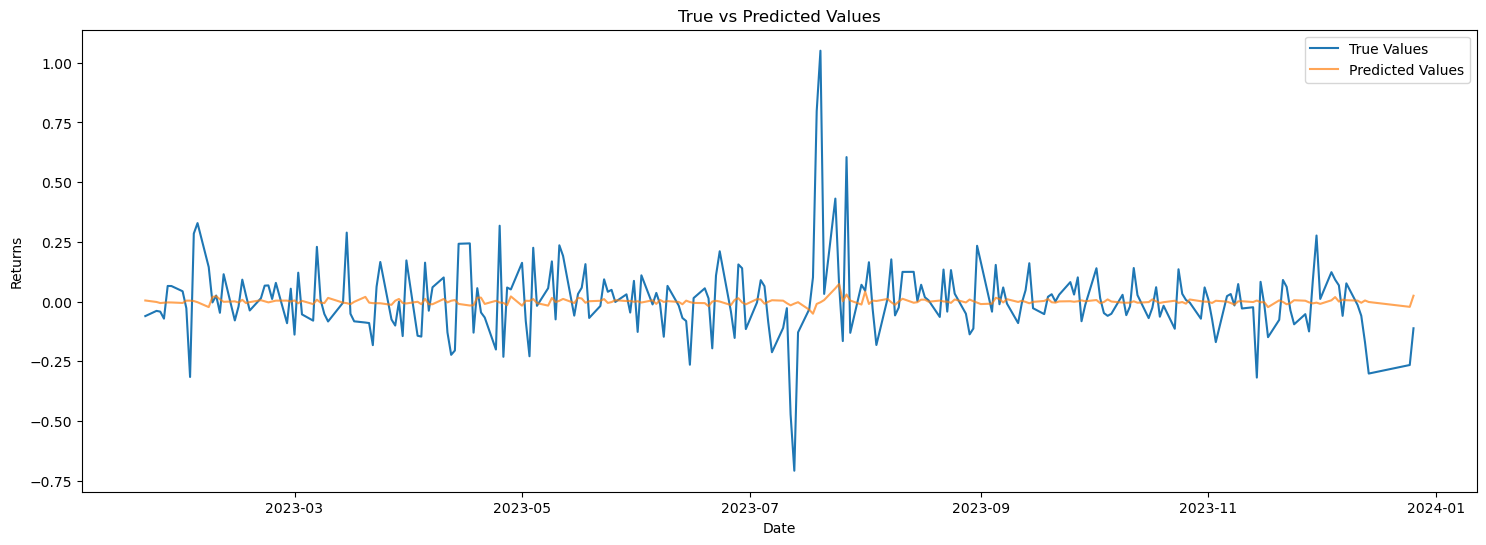

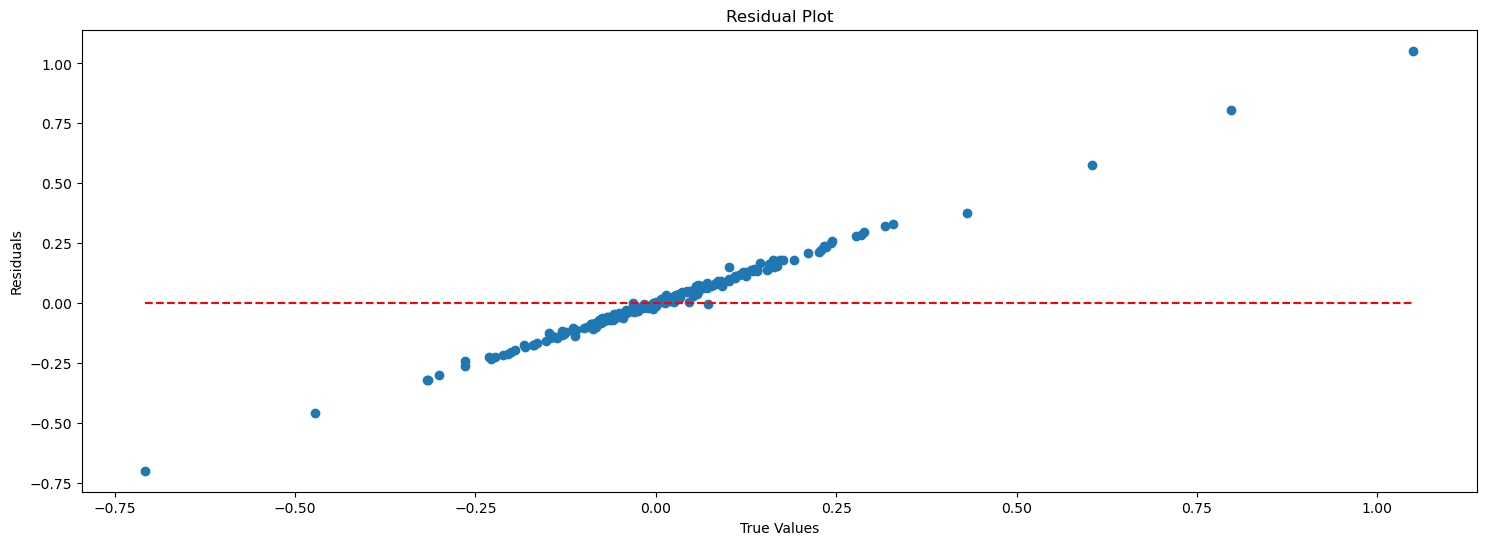

In [23]:
plt.figure(figsize=(18, 6))
plt.plot(y_test.index, y_test, label='True Values')
plt.plot(y_test.index, y_pred, label='Predicted Values', alpha=0.7)
plt.legend()
plt.title('True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(18, 6))
plt.scatter(y_test, residuals)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max(), colors='r', linestyles='dashed')
plt.title('Residual Plot')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.show()


## Random Forest Regressor

In [24]:
selector = SelectKBest(score_func=f_regression, k='all')
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

In [25]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_selected, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test_selected)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Random Forest MSE: {mse_rf}')
print(f'Random Forest R^2: {r2_rf}')

Random Forest MSE: 0.02564192232617393
Random Forest R^2: 0.01006493520501095


In [26]:
param_dist = {
    'n_estimators': randint(100, 300),
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': randint(2, 6),
    'min_samples_leaf': randint(1, 3)
}

random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=20, cv=3, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
random_search.fit(X_train_selected, y_train)

best_params_rf = random_search.best_params_
best_rf_model = random_search.best_estimator_

print(f'Best Parameters: {best_params_rf}')


Best Parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 159}


In [27]:
best_rf_model = RandomForestRegressor(
    max_depth=30,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=159,
    random_state=42
)

best_rf_model.fit(X_train_selected, y_train)

y_pred_best_rf = best_rf_model.predict(X_test_selected)

mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

print(f'Best Random Forest MSE: {mse_best_rf}')
print(f'Best Random Forest R^2: {r2_best_rf}')


Best Random Forest MSE: 0.022654310277710622
Best Random Forest R^2: 0.12540503682285686


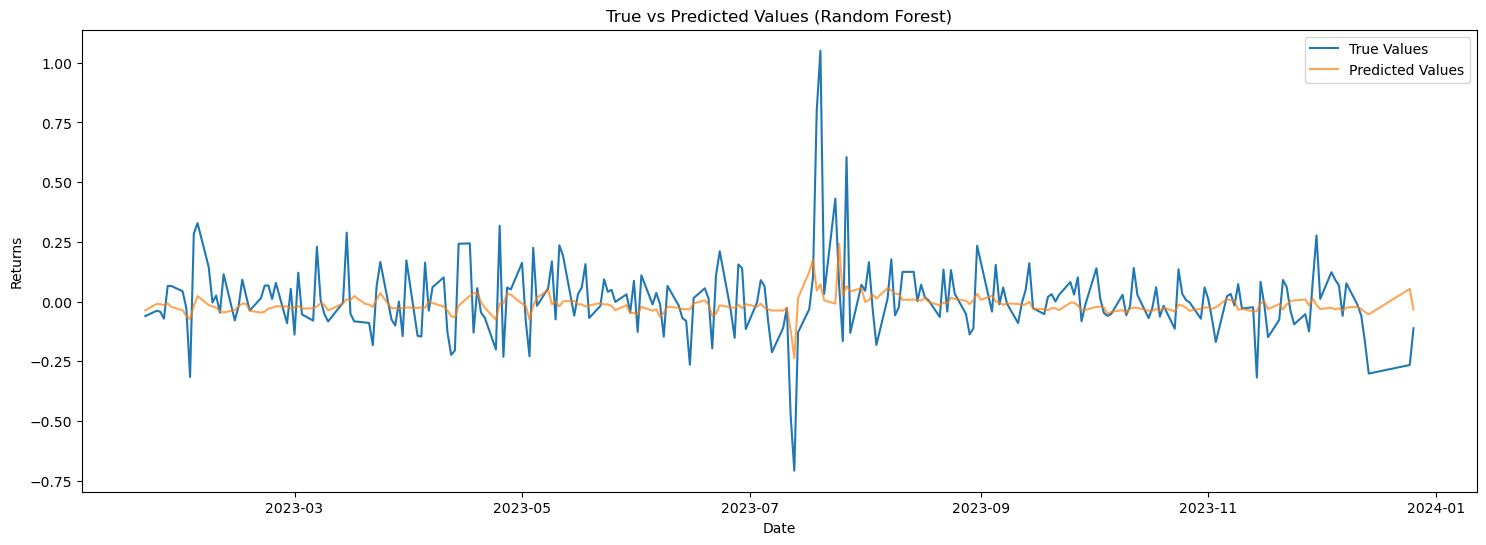

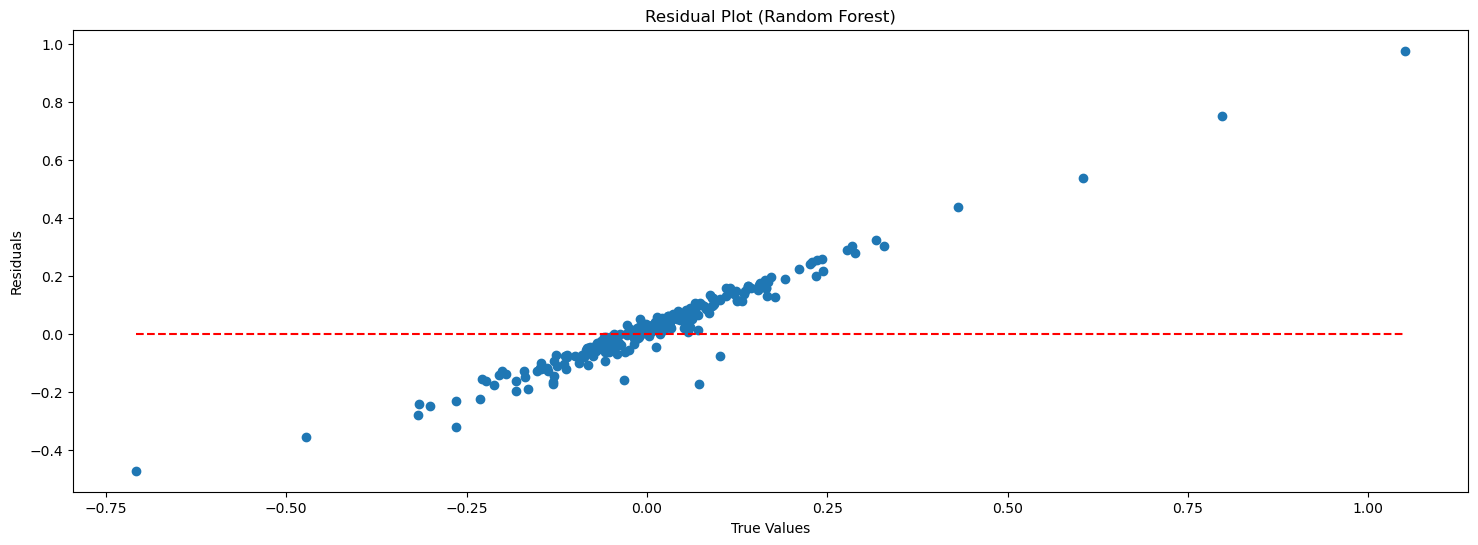

In [28]:
plt.figure(figsize=(18, 6))
plt.plot(y_test.index, y_test, label='True Values')
plt.plot(y_test.index, y_pred_best_rf, label='Predicted Values', alpha=0.7)
plt.legend()
plt.title('True vs Predicted Values (Random Forest)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()

residuals_best_rf = y_test - y_pred_best_rf
plt.figure(figsize=(18, 6))
plt.scatter(y_test, residuals_best_rf)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max(), colors='r', linestyles='dashed')
plt.title('Residual Plot (Random Forest)')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.show()


## Gradient Boosting Regressor

In [29]:
selector = SelectKBest(score_func=f_regression, k='all')
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

In [30]:
gbm_model = GradientBoostingRegressor(random_state=42)

gbm_model.fit(X_train_selected, y_train)

y_pred_gbm = gbm_model.predict(X_test_selected)

mse_gbm = mean_squared_error(y_test, y_pred_gbm)
r2_gbm = r2_score(y_test, y_pred_gbm)

print(f'Gradient Boosting MSE: {mse_gbm}')
print(f'Gradient Boosting R^2: {r2_gbm}')


Gradient Boosting MSE: 0.024457050393082786
Gradient Boosting R^2: 0.055808240209139326


In [31]:
param_dist_gb = {
    'n_estimators': randint(50, 300),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'subsample': uniform(0.6, 0.4),
    'max_features': ['auto', 'sqrt', 'log2', None]
}

gb_model = GradientBoostingRegressor(random_state=42)

random_search_gb = RandomizedSearchCV(estimator=gb_model, param_distributions=param_dist_gb, n_iter=50, cv=3, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
random_search_gb.fit(X_train_selected, y_train)

best_params_gb = random_search_gb.best_params_
best_gb_model = random_search_gb.best_estimator_

print(f'Best Parameters: {best_params_gb}')


Best Parameters: {'learning_rate': 0.017625738023228556, 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 18, 'n_estimators': 101, 'subsample': 0.8253102287905535}


In [32]:
gbm_model = GradientBoostingRegressor(
    n_estimators=101,
    max_depth=7,
    learning_rate=0.017625738023228556,
    subsample=0.8253102287905535,
    min_samples_split=18,
    min_samples_leaf=7,
    max_features='log2',
    random_state=42
)

gbm_model.fit(X_train_selected, y_train)

y_pred_gbm = gbm_model.predict(X_test_selected)

mse_gbm = mean_squared_error(y_test, y_pred_gbm)
r2_gbm = r2_score(y_test, y_pred_gbm)

print(f'Gradient Boosting MSE: {mse_gbm}')
print(f'Gradient Boosting R^2: {r2_gbm}')



Gradient Boosting MSE: 0.023405988597436877
Gradient Boosting R^2: 0.09638565533195953


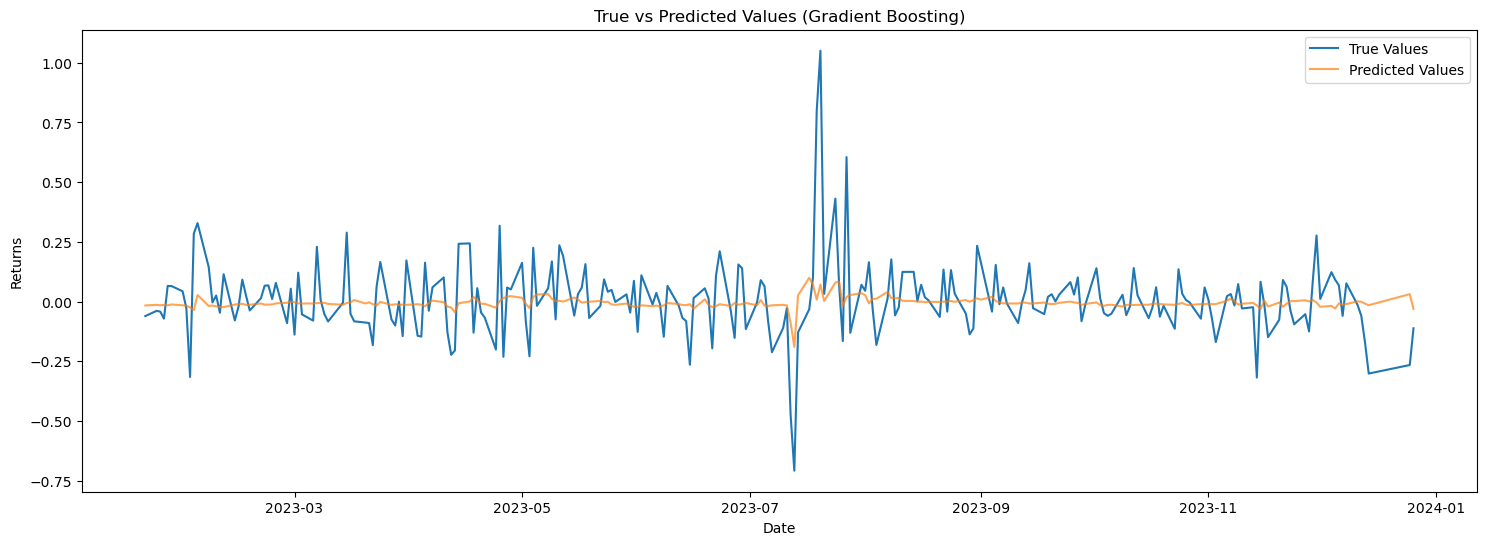

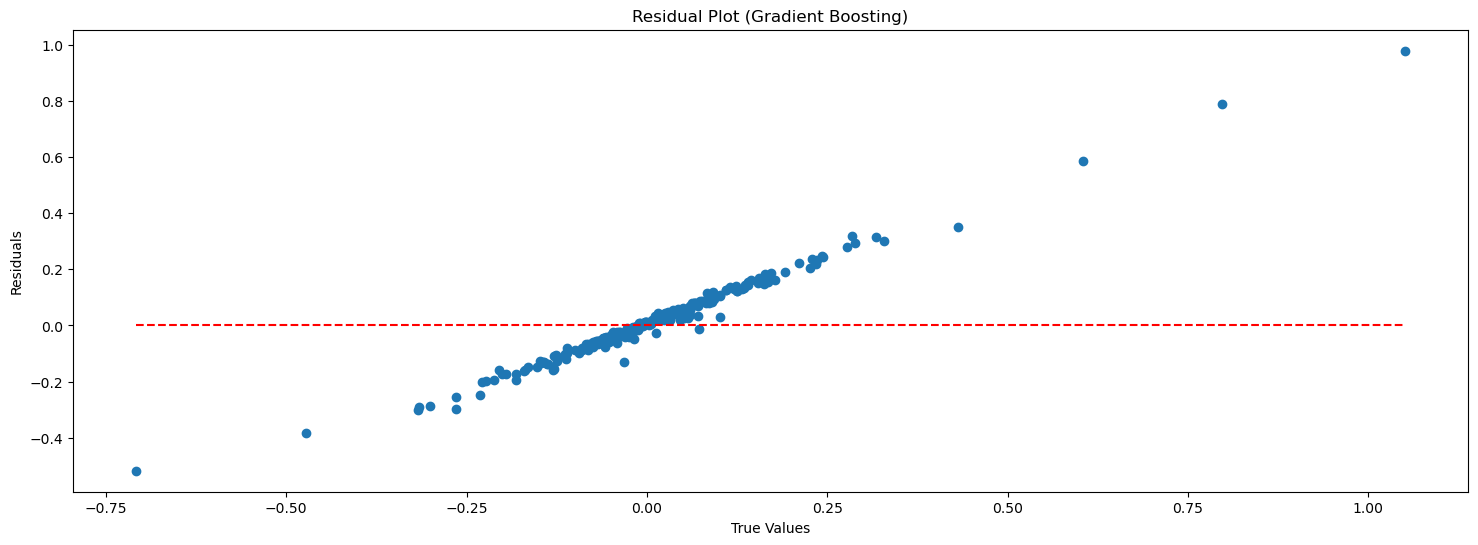

In [33]:
plt.figure(figsize=(18, 6))
plt.plot(y_test.index, y_test, label='True Values')
plt.plot(y_test.index, y_pred_gbm, label='Predicted Values', alpha=0.7)
plt.legend()
plt.title('True vs Predicted Values (Gradient Boosting)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()

residuals_gbm = y_test - y_pred_gbm
plt.figure(figsize=(18, 6))
plt.scatter(y_test, residuals_gbm)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max(), colors='r', linestyles='dashed')
plt.title('Residual Plot (Gradient Boosting)')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.show()


# XGBoost

In [34]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_model.predict(X_test_scaled)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f'XGBoost MSE: {mse_xgb}')
print(f'XGBoost R^2: {r2_xgb}')


XGBoost MSE: 0.02189915730289056
XGBoost R^2: 0.15455856125638057


In [35]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_params_xgb = grid_search.best_params_
best_xgb_model = grid_search.best_estimator_

print(f'Best Parameters: {best_params_xgb}')

y_pred_best_xgb = best_xgb_model.predict(X_test_scaled)
mse_best_xgb = mean_squared_error(y_test, y_pred_best_xgb)
r2_best_xgb = r2_score(y_test, y_pred_best_xgb)

print(f'Best XGBoost MSE: {mse_best_xgb}')
print(f'Best XGBoost R^2: {r2_best_xgb}')


Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}
Best XGBoost MSE: 0.02631628815758483
Best XGBoost R^2: -0.015969711282153964


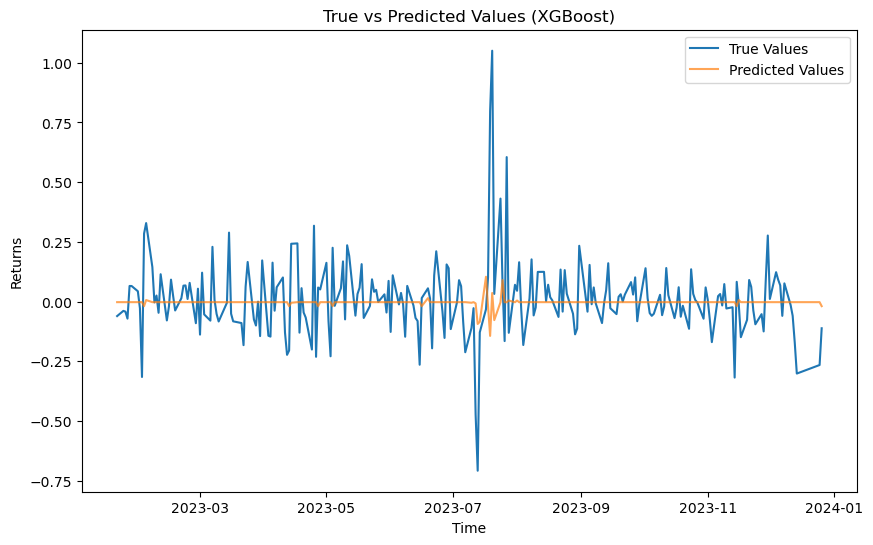

In [36]:
# Plot the true vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='True Values')
plt.plot(y_test.index, y_pred_best_xgb, label='Predicted Values', alpha=0.7)
plt.legend()
plt.title('True vs Predicted Values (XGBoost)')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.show()



# Best Performing Model

In [37]:
results = {
    "Linear Regression": {'MSE': mse, 'R²': r2},
    "Random Forest": {'MSE': mse_best_rf, 'R²': r2_best_rf},
    "Gradient Boosting": {'MSE': mse_gbm, 'R²': r2_gbm},
    "XGBoost": {'MSE': mse_best_xgb, 'R²': r2_best_xgb},
}

for model_name, metrics in results.items():
    print(f'{model_name} MSE: {metrics["MSE"]}')
    print(f'{model_name} R²: {metrics["R²"]}')
    print(" ")


Linear Regression MSE: 0.025753834664123725
Linear Regression R²: 0.0057444343427723865
 
Random Forest MSE: 0.022654310277710622
Random Forest R²: 0.12540503682285686
 
Gradient Boosting MSE: 0.023405988597436877
Gradient Boosting R²: 0.09638565533195953
 
XGBoost MSE: 0.02631628815758483
XGBoost R²: -0.015969711282153964
 


In [38]:
best_model_name = min(results, key=lambda k: results[k]['MSE'])
best_model_metrics = results[best_model_name]

print(f'\nBest Model: {best_model_name}')
print(f'Best Model MSE: {best_model_metrics["MSE"]}')
print(f'Best Model R²: {best_model_metrics["R²"]}')



Best Model: Random Forest
Best Model MSE: 0.022654310277710622
Best Model R²: 0.12540503682285686


# Model Export

In [39]:
params = best_rf_model.get_params()

with open('rf_model.bin', 'wb') as f:
    for param in params.values():
        np.save(f, param)

print("Model parameters saved successfully.")

Model parameters saved successfully.


# Performance Analysis

In [40]:
analysis = pd.read_csv('testergraph.report.2024.07.01v3.csv', delimiter="\t", parse_dates=True, encoding='utf-16')
analysis

,<DATE>,<BALANCE>,<EQUITY>,<DEPOSIT LOAD>
0,2024.01.01 00:00,10000.0,10000.0,0.0000
1,2024.01.02 00:28,9970.0,9753.6,0.0000
2,2024.01.02 00:34,9970.0,9749.2,81.0323
3,2024.01.02 00:35,9950.0,9693.8,81.4954
4,2024.01.02 00:35,9950.0,9686.8,81.5543
...,...,...,...,...
16681,2024.01.30 22:12,230.0,230.2,86.8810
16682,2024.01.30 22:14,230.0,230.5,43.3839
16683,2024.01.30 22:40,230.0,236.0,84.7458
16684,2024.01.30 23:00,230.0,225.4,44.3656


In [41]:
analysis.columns = ["date", "balance", "equity", "deposit load"]
analysis['date'] = pd.to_datetime(analysis['date'])
print(analysis.head())

                 date  balance   equity  deposit load
0 2024-01-01 00:00:00  10000.0  10000.0        0.0000
1 2024-01-02 00:28:00   9970.0   9753.6        0.0000
2 2024-01-02 00:34:00   9970.0   9749.2       81.0323
3 2024-01-02 00:35:00   9950.0   9693.8       81.4954
4 2024-01-02 00:35:00   9950.0   9686.8       81.5543


In [42]:
net_profit = analysis['balance'].iloc[-1] - analysis['balance'].iloc[0]

cumulative_max = analysis['balance'].cummax()
drawdown = analysis['balance'] - cumulative_max
max_drawdown = drawdown.min()

total_trades = len(analysis)

# Print performance metrics
print(f"Net Profit: {net_profit}")
print(f"Max Drawdown: {max_drawdown}")
print(f"Total Trades: {total_trades}")



Net Profit: -9772.3
Max Drawdown: -11845.0
Total Trades: 16686


In [43]:

analysis['daily_return'] = analysis['balance'].pct_change()

mean_return = analysis['daily_return'].mean()
median_return = analysis['daily_return'].median()
std_dev_return = analysis['daily_return'].std()
variance_return = analysis['daily_return'].var()
skewness_return = analysis['daily_return'].skew()
kurtosis_return = analysis['daily_return'].kurt()

print(f"Mean Daily Return: {mean_return}")
print(f"Median Daily Return: {median_return}")
print(f"Standard Deviation of Returns: {std_dev_return}")
print(f"Variance of Returns: {variance_return}")
print(f"Skewness of Returns: {skewness_return}")
print(f"Kurtosis of Returns: {kurtosis_return}")

t_stat, p_value = stats.ttest_1samp(analysis['daily_return'].dropna(), 0)
print(f"t-statistic: {t_stat}, p-value: {p_value}")


Mean Daily Return: -0.00020219425798234477
Median Daily Return: 0.0
Standard Deviation of Returns: 0.00699356311308398
Variance of Returns: 4.890992501668889e-05
Skewness of Returns: -0.01466124119792656
Kurtosis of Returns: 12.981939051810338
t-statistic: -3.7345082664520586, p-value: 0.0001887080415799374


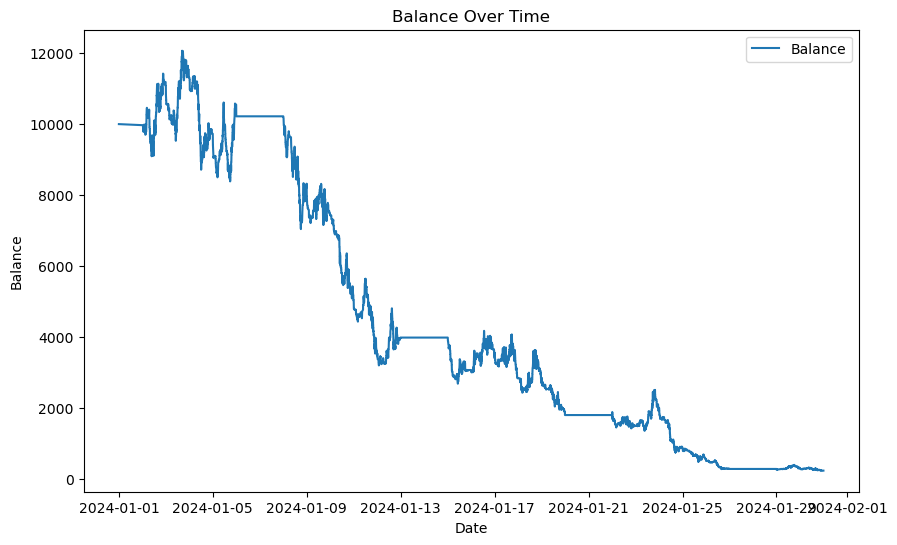

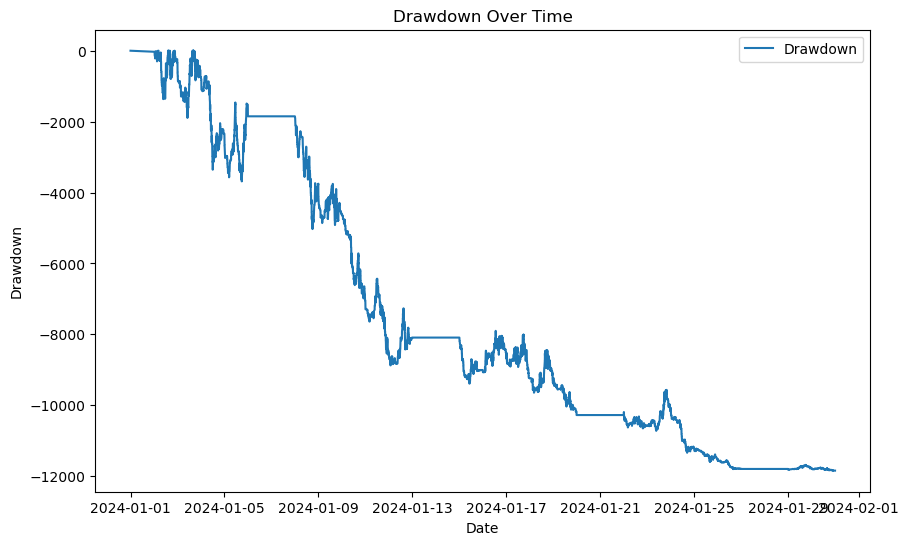

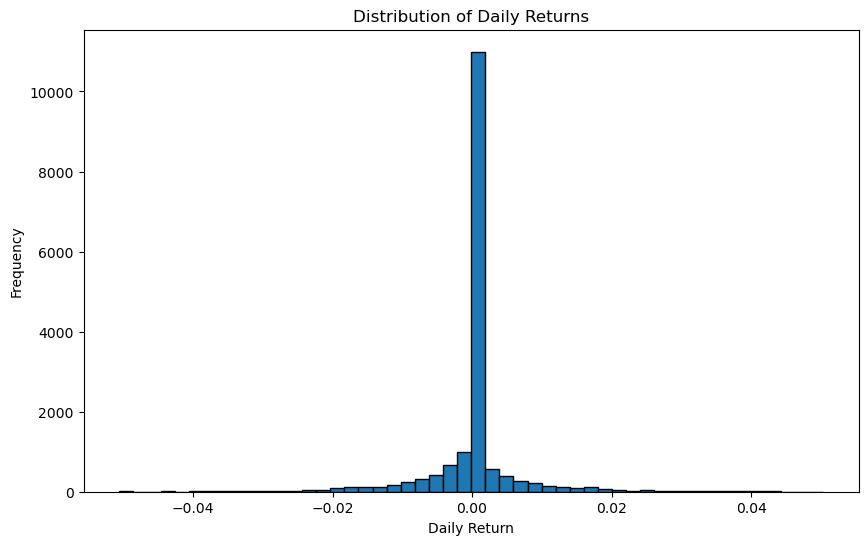

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(analysis['date'], analysis['balance'], label='Balance')
plt.xlabel('Date')
plt.ylabel('Balance')
plt.title('Balance Over Time')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(analysis['date'], drawdown, label='Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.title('Drawdown Over Time')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(analysis['daily_return'].dropna(), bins=50, edgecolor='black')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.title('Distribution of Daily Returns')
plt.show()


# Statistical Analysis

Mean Daily Return: -0.00020219425798234477
Standard Deviation of Returns: 0.00699356311308398
t-statistic: -3.7345082664520586, p-value: 0.0001887080415799374
Confidence Interval: (-0.013910320557687149, 0.013505932041722459)
                            OLS Regression Results                            
Dep. Variable:                balance   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 2.187e+05
Date:                Mon, 01 Jul 2024   Prob (F-statistic):               0.00
Time:                        21:11:40   Log-Likelihood:            -1.3782e+05
No. Observations:               16686   AIC:                         2.757e+05
Df Residuals:                   16684   BIC:                         2.757e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                          

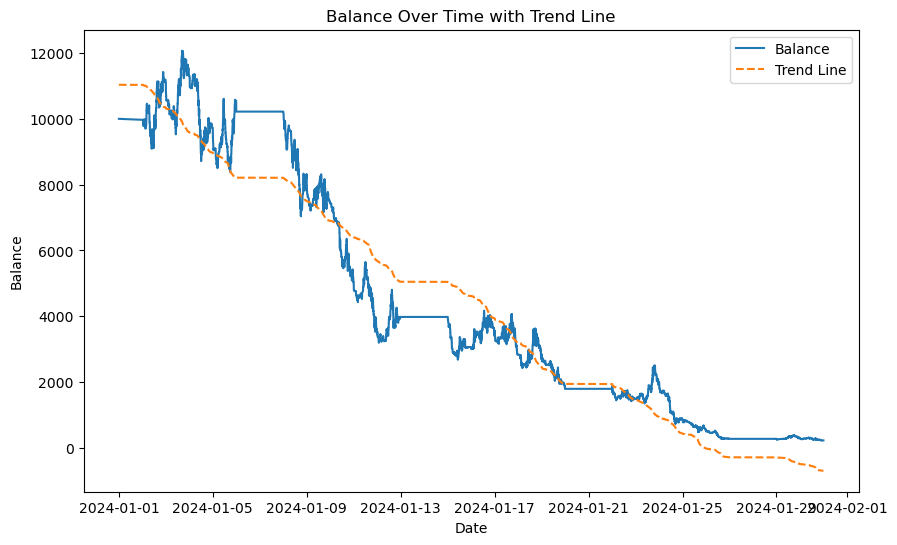

In [45]:
analysis['daily_return'] = analysis['balance'].pct_change()

daily_returns = analysis['daily_return'].dropna()

mean_return = daily_returns.mean()
std_dev_return = daily_returns.std()

print(f"Mean Daily Return: {mean_return}")
print(f"Standard Deviation of Returns: {std_dev_return}")

t_stat, p_value = stats.ttest_1samp(daily_returns, 0)
print(f"t-statistic: {t_stat}, p-value: {p_value}")

confidence_level = 0.95
degrees_freedom = len(daily_returns) - 1
confidence_interval = stats.t.interval(confidence_level, degrees_freedom, mean_return, std_dev_return)

print(f"Confidence Interval: {confidence_interval}")

X = sm.add_constant(analysis.index)  # Add a constant to the predictor
model = sm.OLS(analysis['balance'], X).fit()
predictions = model.predict(X)

print(model.summary())

plt.figure(figsize=(10, 6))
plt.plot(analysis['date'], analysis['balance'], label='Balance')
plt.plot(analysis['date'], predictions, label='Trend Line', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Balance')
plt.title('Balance Over Time with Trend Line')
plt.legend()
plt.show()


In [46]:
import numpy as np

def sharpe_ratio(returns):
    return np.mean(returns) / np.std(returns)

n_iterations = 1000
sharpe_ratios = []

for _ in range(n_iterations):
    sample = np.random.choice(daily_returns, size=len(daily_returns), replace=True)
    sharpe_ratios.append(sharpe_ratio(sample))

sharpe_ratios = np.array(sharpe_ratios)
sharpe_ci = np.percentile(sharpe_ratios, [2.5, 97.5])

print(f"Sharpe Ratio Confidence Interval: {sharpe_ci}")


Sharpe Ratio Confidence Interval: [-0.04346918 -0.01303585]


In [47]:
print(analysis.head())

analysis['daily_return'] = analysis['balance'].pct_change().dropna()
daily_returns = analysis['daily_return']
print(daily_returns.describe())


                 date  balance   equity  deposit load  daily_return
0 2024-01-01 00:00:00  10000.0  10000.0        0.0000           NaN
1 2024-01-02 00:28:00   9970.0   9753.6        0.0000     -0.003000
2 2024-01-02 00:34:00   9970.0   9749.2       81.0323      0.000000
3 2024-01-02 00:35:00   9950.0   9693.8       81.4954     -0.002006
4 2024-01-02 00:35:00   9950.0   9686.8       81.5543      0.000000
count    16685.000000
mean        -0.000202
std          0.006994
min         -0.050633
25%          0.000000
50%          0.000000
75%          0.000000
max          0.050360
Name: daily_return, dtype: float64
